In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import SVG
import sknetwork as skn
from sklearn.metrics import adjusted_mutual_info_score as AMI


# Toy Dataset

The graph represents links between 30 wikipedia pages, 10 each from topics: science, art or philosophy.
There is a feature vector for each page, each feture representing a keyword count.

* `A`: csr adjacency matrix, directed (30 nodes)
* `names`: name of each node (wikipedia page); we also define `names_dict` for quick reference
* `features`: csr matrix of binary features
* `name_features`: name of each feature (11 keywords)
* `labels`: numpy array, node label (0, 1 or 2)
* `name_labels`: name of the labels (category of page: science, art or philosophy)


In [2]:
from sknetwork.data import art_philo_science

graph = art_philo_science(metadata=True)

## adjacency and features (both in csr format)
A = graph.adjacency
features = graph.biadjacency

## metadata
names = graph.names
names_dict = {v:k for k,v in enumerate(names)}
names_features = graph.names_col
names_labels = graph.names_labels
labels = graph.labels


In [3]:
graph.keys()

dict_keys(['adjacency', 'names', 'position', 'labels', 'names_labels', 'biadjacency', 'names_col', 'name'])

## Visualization - adjacency (directed graph) and features

In [4]:
from sknetwork.embedding import Spring, SVD
from sknetwork.visualization import svg_graph, svg_bigraph

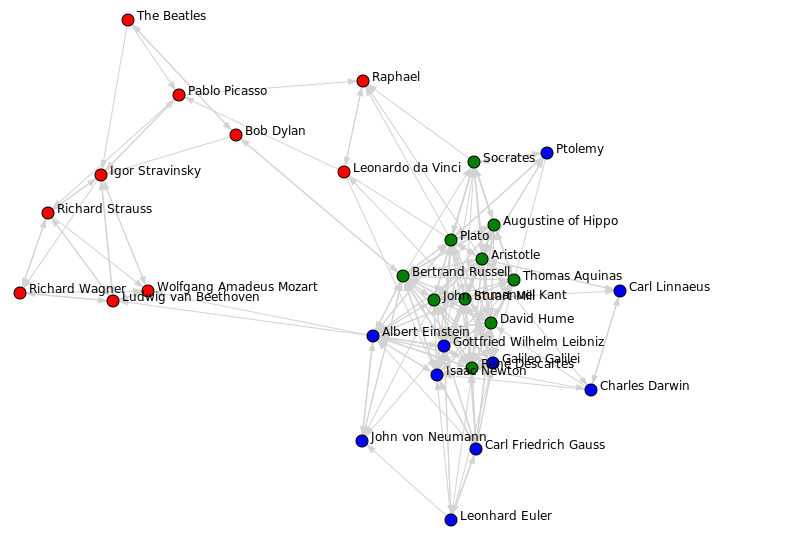

In [5]:
layout = Spring(position_init='spectral').fit_transform(A)
image = svg_graph(A, names=names, position=layout, width=600, height=500, labels=labels,
                  node_size=6, edge_color='lightgray')
SVG(image)

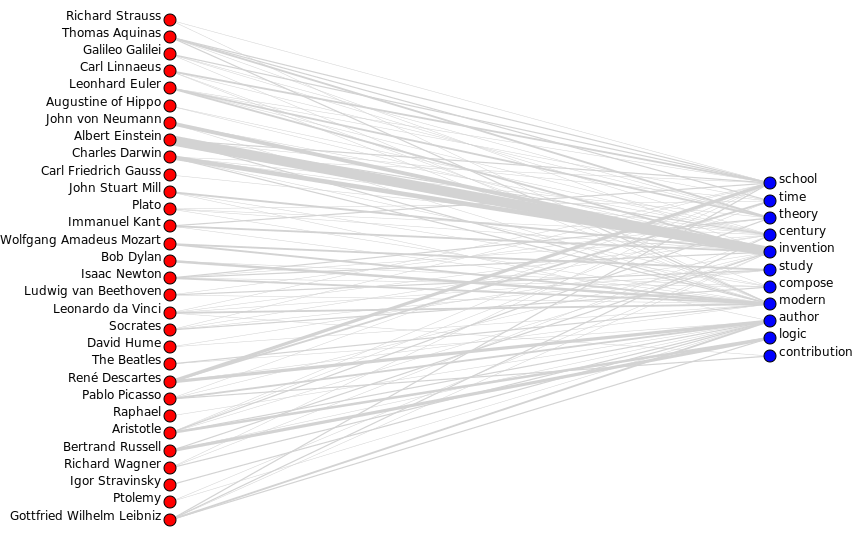

In [6]:
image = svg_bigraph(features, names_row=names, names_col=names_features, width=600, height=500, 
                    color_row='red', color_col='blue', node_size=6, edge_color='lightgray')
SVG(image)


## Node centrality

Below we illustrate a few centrality measaures as well as the top nodes for each.

* degree
* PageRank
* Betweenness
* HITS (hub/authority scores)

We also illustrate personalized PageRank given some seed node(s).


In [7]:
from sknetwork.ranking import PageRank, Betweenness, HITS
from sknetwork.utils import get_degrees, get_weights


In [8]:
## in/out degree, total degree
out_deg = get_degrees(A)
in_deg = get_degrees(A, transpose=True)
deg = out_deg + in_deg
top_deg = deg.argsort()[::-1]

## top total degree nodes
print(names[top_deg[:3]])


['Aristotle' 'Bertrand Russell' 'Plato']


In [9]:
## top PageRank 
pagerank = PageRank()
top_pr = pagerank.fit_predict(A).argsort()[::-1]
print(names[top_pr[:3]])


['Wolfgang Amadeus Mozart' 'Ludwig van Beethoven' 'Aristotle']


In [10]:
## top Betweenness 
between = Betweenness()
top_bet = between.fit_predict(A).argsort()[::-1]
print(names[top_bet[:3]])


['Leonardo da Vinci' 'Aristotle' 'Raphael']


In [11]:
## top hub/authority scores
hits = HITS()
top_hub = hits.fit_predict(A).argsort()[::-1]
top_auth = hits.fit_predict(A.transpose()).argsort()[::-1]
print('top hub:',names[top_hub[:3]])
print('top authority:',names[top_auth[:3]])


top hub: ['Immanuel Kant' 'Aristotle' 'David Hume']
top authority: ['René Descartes' 'Aristotle' 'David Hume']


In [12]:
## personalized PageRank - top nodes given 1+ seed nodes
seeds = {'Aristotle','Socrates'}
indices = [k for k,v in enumerate(names) if v in seeds]
weights = {x:1 for x in indices}
top_ppr = pagerank.fit_predict(A, weights).argsort()[::-1]
print(names[top_ppr[:4]])


['Aristotle' 'Socrates' 'Plato' 'Augustine of Hippo']


## Shortest paths

We look at the number of hops in the shortest path, either **from** source node(s) or **to** destination node(s).

We also look at the undirected version.


In [13]:
from sknetwork.path import get_distances, get_shortest_path


In [14]:
## path length FROM the source
seed = 'Leonhard Euler'
source = np.where(names==seed)[0][0]
distances = get_distances(A, source)
print(Counter(distances))

## which nodes are furthest away
print('furthest nodes:',names[distances == max(distances)])

Counter({2: 11, 3: 7, 1: 6, 4: 5, 0: 1})
furthest nodes: ['Richard Wagner' 'Igor Stravinsky' 'The Beatles' 'Richard Strauss'
 'Pablo Picasso']


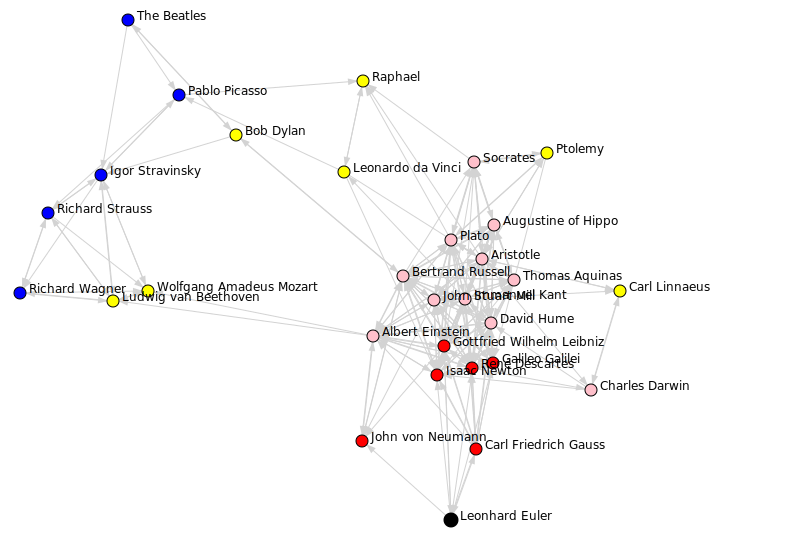

In [15]:
## color w.r.t. distance from seed node
image = svg_graph(A, names=names, position=layout, width=600, height=500, seeds=source,
                  labels=distances, node_size=6, node_order = np.argsort(-distances),
                  label_colors=['black','red','pink','yellow','blue'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


In [16]:
## path length TO the destination
seed = 'Leonhard Euler'
dest = np.where(names==seed)[0][0]
distances = get_distances(A.transpose(), dest)
print(Counter(distances))

## which nodes are furthest away
print('furthest nodes:',names[distances >= max(distances)-1])

Counter({2: 12, 3: 7, 7: 3, 1: 2, 4: 2, 0: 1, 8: 1, 6: 1, 5: 1})
furthest nodes: ['Richard Wagner' 'Ludwig van Beethoven' 'Wolfgang Amadeus Mozart'
 'Richard Strauss']


## Clustering


In [17]:
from sknetwork.clustering import Louvain
from sknetwork.utils import directed2undirected
 

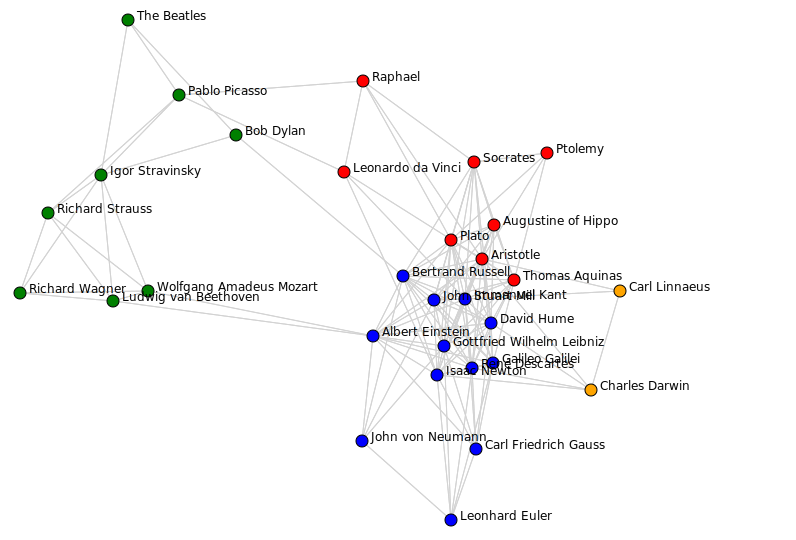

In [18]:
A_und = directed2undirected(A)
louvain = Louvain(shuffle_nodes=True, resolution=1.0)
labels_pred = louvain.fit_predict(A_und)
image = svg_graph(A_und, names=names, position=layout, width=600, height=500, 
                  labels=labels_pred, node_size=6, edge_color='lightgray', display_edge_weight=False)
SVG(image)


In [19]:
AMI(labels,labels_pred)

0.4424585757553335

### igraph - several other clustering algorithms

In [20]:
import igraph as ig
import partition_igraph

In [21]:
## igraph graph given adjacency
g = ig.Graph.Adjacency(A_und, 'undirected')

## run a few other clustering algorithms
ecg = g.community_ecg(final='leiden', ens_size=20, refuse_score=True)
ecg_class = ecg.membership
infomap_class = g.community_infomap().membership
leiden_class = g.community_leiden(objective_function='modularity').membership


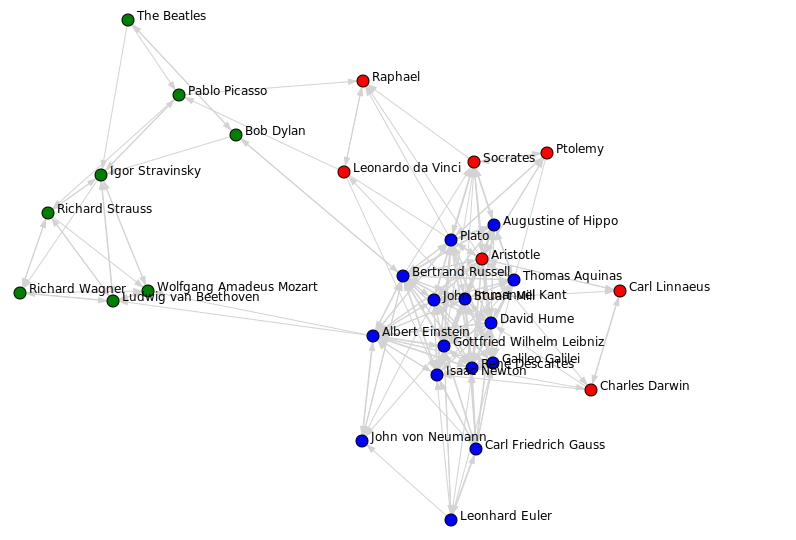

In [22]:
## Leiden
image = svg_graph(A, names=names, position=layout, width=600, height=500, 
                  labels=leiden_class, node_size=6, edge_color='lightgray', display_edge_weight=False)
SVG(image)


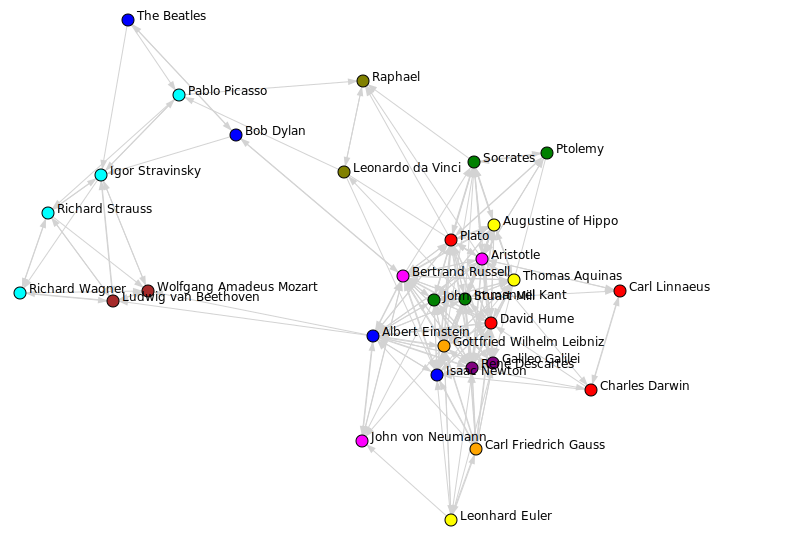

In [23]:
## infomap
image = svg_graph(A, names=names, position=layout, width=600, height=500, 
                  labels=infomap_class, node_size=6, edge_color='lightgray', display_edge_weight=False)
SVG(image)


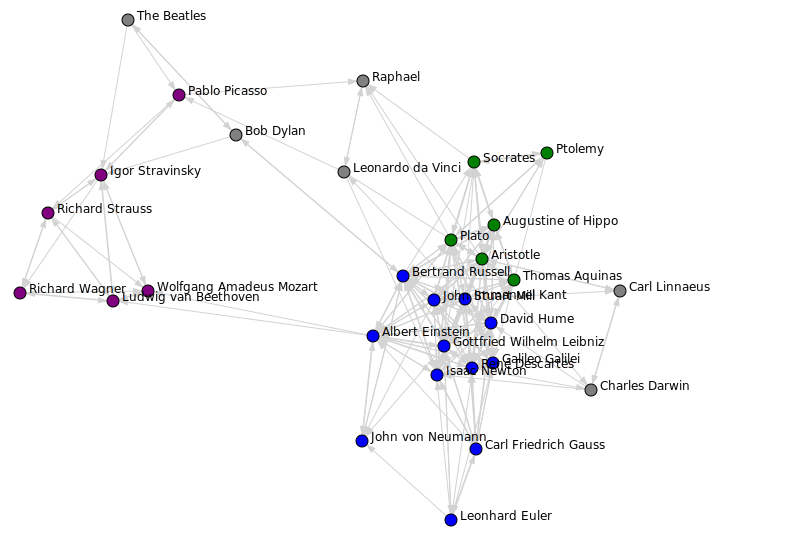

In [24]:
## ECG with 'refuse to cluster' option
ecg_refuse = np.array(ecg_class)
ecg_refuse[np.array(ecg.refuse_overall) > .67] = -1
ctr = Counter(ecg_refuse)
drop = [k for k in ctr.keys() if k>=0 and ctr[k]<=2]
for d in drop:
    ecg_refuse[ecg_refuse==d]=-1
image = svg_graph(A, names=names, position=layout, width=600, height=500, 
                  labels=ecg_refuse, node_size=6, edge_color='lightgray', display_edge_weight=False)
SVG(image)


## Semi-supervised learning

In [25]:
from sknetwork.classification import PageRankClassifier, get_accuracy_score

In [26]:
## fix (ground-truth) labels for a few seed nodes, and learn the other labels
seeds = ['Socrates', 'Thomas Aquinas', 'Galileo Galilei', 'Leonhard Euler',
         'Richard Strauss', 'The Beatles']
labels_ssl = {names_dict[x]:labels[names_dict[x]] for x in seeds}

## classifier
pr = PageRankClassifier()
labels_pred = pr.fit_predict(A, labels_ssl)
print('accuracy:',get_accuracy_score(labels, labels_pred))


accuracy: 0.6666666666666666


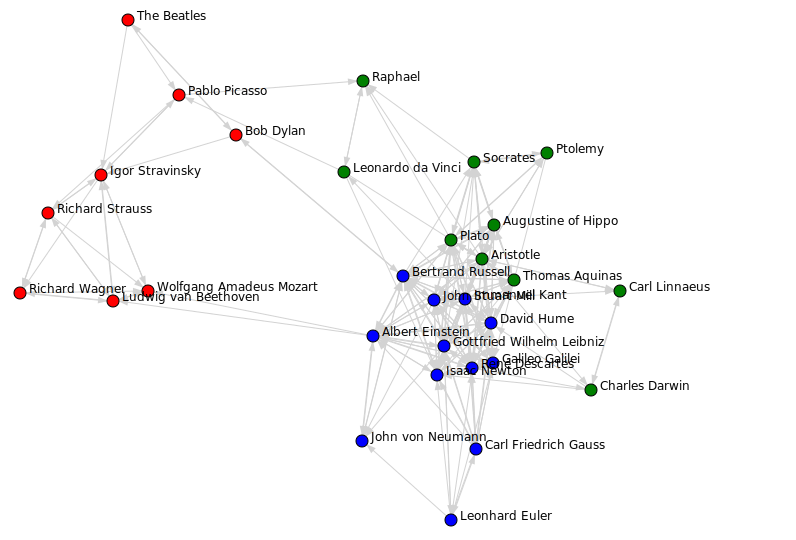

In [27]:
image = svg_graph(A, names=names, position=layout, width=600, height=500, 
                  labels=labels_pred, node_size=6, edge_color='lightgray', 
                  display_edge_weight=False)
SVG(image)


In [28]:
from ipywidgets import interact
import cairosvg
from PIL import Image
from io import BytesIO


In [29]:
def plot_ssl(threshold=0.5):
    labs = labels_pred.copy()
    proba = np.max(pr.predict_proba(),axis=1)
    labs[proba <= threshold] = -1
    image = svg_graph(A, position=layout, width=400, height=400,
                      labels=labs, node_size=6, edge_color='lightgray', 
                      display_edge_weight=False)
    img_png = cairosvg.svg2png(image, dpi=1200, scale=3)
    img = Image.open(BytesIO(img_png))
    plt.figure(figsize = (7.5, 6))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

In [30]:
interactive_plot = interact(plot_ssl, threshold=(0,1,.02));
interactive_plot;


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

## GNN -- classification


In [31]:
from scipy.sparse import hstack
from sknetwork.gnn import GNNClassifier as GNN


In [32]:
# Training set
labels_train = labels.copy()
np.random.seed(321)
train_mask = np.random.random(size=len(labels_train)) < 0.3 ## keep 30% for testing
labels_train[train_mask] = -1 ## negative labels are ignored in training


In [33]:
# GNN classifier with a single hidden layer
hidden_dim = 5
n_labels = 3

gnn = GNN(dims=[hidden_dim, n_labels],
                layer_types='Conv',
                activations='ReLu',
                verbose=True)

## for node features, we try: the unweighted adjacency matrix
node_features = hstack((A,features))
gnn_pred = gnn.fit_predict(A, node_features, labels=labels_train, 
                           n_epochs=100, random_state=42, history=True)


In epoch   0, loss: 1.266, train accuracy: 0.333
In epoch  10, loss: 1.051, train accuracy: 0.500
In epoch  20, loss: 0.763, train accuracy: 0.833
In epoch  30, loss: 0.696, train accuracy: 0.889
In epoch  40, loss: 0.674, train accuracy: 0.889
In epoch  50, loss: 0.645, train accuracy: 0.944
In epoch  60, loss: 0.640, train accuracy: 0.889
In epoch  70, loss: 0.628, train accuracy: 0.944
In epoch  80, loss: 0.625, train accuracy: 0.944
In epoch  90, loss: 0.621, train accuracy: 0.944


In [34]:
## test set accuracy
get_accuracy_score(labels[train_mask], gnn_pred[train_mask])


0.8333333333333334

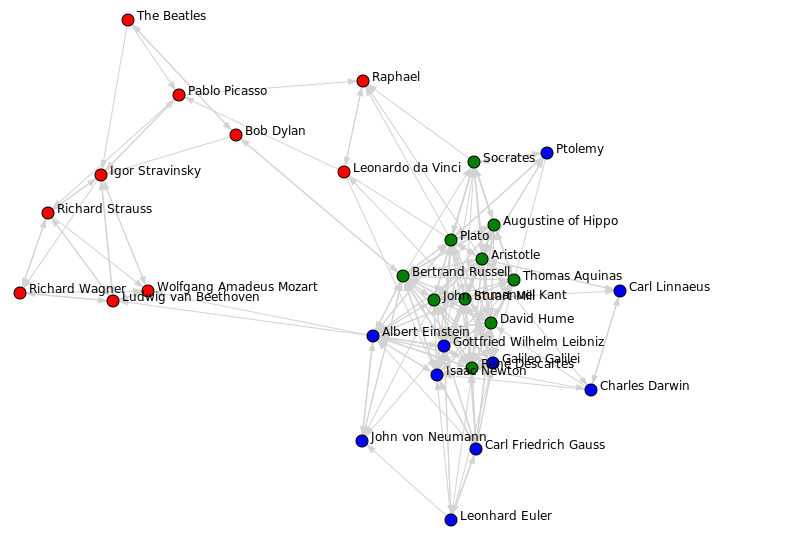

In [35]:
image = svg_graph(A, names=names, position=layout, width=600, height=500, labels=labels,
                  node_size=6, edge_color='lightgray')
SVG(image)


## Coreness - show max core

In [36]:
from sknetwork.topology import get_core_decomposition as coreness
core = coreness(A_und)

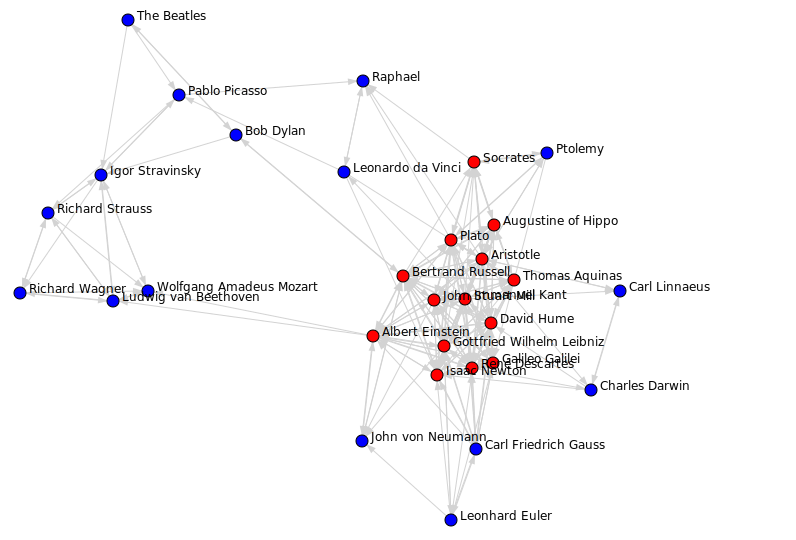

In [37]:
image = svg_graph(A, names=names, position=layout, width=600, height=500, labels=(core==max(core)),
                  node_size=6, edge_color='lightgray')
SVG(image)


### Triangles, Triads

* looking for **triangles** and higher order **cliques** reveals dense sub-groups
* the **clustering coefficient** measures the propostion of closed wedges (connected friends of a friend)
* for directed graphs, looking at the **triad census** yields some interesting motif-based features


In [38]:
from sknetwork.topology import count_triangles, get_clustering_coefficient, count_cliques


In [39]:
print('number of triangles:',count_triangles(A_und))
for i in range(3,11):
    print('number of ',str(i),'cliques:',count_cliques(A_und, clique_size=i))
print('clustering coefficient:',np.round(get_clustering_coefficient(A_und),3))


number of triangles: 335
number of  3 cliques: 335
number of  4 cliques: 600
number of  5 cliques: 786
number of  6 cliques: 725
number of  7 cliques: 458
number of  8 cliques: 189
number of  9 cliques: 46
number of  10 cliques: 5
clustering coefficient: 0.674


In [40]:
## counting triads - igraph implementation is quite fast
g = ig.Graph.Adjacency(A, 'directed')
g.triad_census()


TriadCensus((1360, 562, 1337, 12, 11, 22, 104, 151, 0, 0, 166, 7, 23, 9, 51, 245))

# Transductive learning (semi-supervised) - undirected Graph

Given some labelled nodes (both positive and negative labels, typically +1 and -1), rank all other nodes (labelled with 0) as being closer to the positive/negative labelled ones.

Having negative labels is optional.

### Theory:

Let:
$
G = (V,E),~ |V|=n,~
W = (w_{ij} \ge 0)_{i,j = 1,...,n},~
d_i = \sum_j w_{ij},~
D = diag(d_1,...,d_n). 
$

For a partition $V = S \cup S^c$:

$ Ncut(S,S^c) = \frac{Vol \partial S}{Vol S}  + \frac{Vol \partial S}{Vol S^c} $

where:

$
\partial S = \{e \in E ; |e \cap S| = |e \cap S^c| = 1 \},~
Vol(S) = \sum_{v \in S} d(v),~
Vol(\partial S) = \sum_{(v_i, v_j) \in \partial S} w_{ij}.
$

From a random walk view:

$P = D^{-1}W, ~~ Ncut(S,S^c) = P(S|S^c) + P(S^c|S)$.

The problem can be solved by relaxing over real values:

$ f^* = \underset{f \in \mathbb{R}^n}{\operatorname{argmin}} f^t \Delta f,~ f \perp D^{1/2} \cdot 1,~ ||f||^2 = 1. $
where:
$ \Delta = I - D^{-1/2} W D^{-1/2} $
the (normalized) graph Laplacian.

$
f^* = \underset{f \in H(V)}{\operatorname{argmin}} \left( \Omega(f) + {\mu} ||f-y||^2
\right) \\
\Omega(f) = <f^t, \Delta f> = \frac{1}{2} \sum_{(v_i,v_j) \in E} w_{ij} \left(\frac{f(v_i)}{\sqrt{d_i}} + \frac{f(v_j)}{\sqrt{d_j}}\right)^2
$

where $y$ is a given vector of initial labels, typically $y_i \in \{-1,0,1\}$.

The solution is given by:
$
f^* = (1-\alpha)(I-\alpha S)^{-1}y,~ \alpha=(1+\mu)^{-1},~ S = I - \Delta. 
$


In [41]:
from scipy.sparse.linalg import cg, inv
from math import sqrt
from scipy.sparse import csr_matrix, diags, identity, rand
## Input: 
##   W: adjacency -- weighted triangular sparse matrix
##   y: initial (seed) values
## Output:
##   x: solution of regularization problem via CG or (slow) explicit matrix inversion
def TLoG_und(W, y, alpha=0.5, inverse=False):
    ## undirected -- make W symmetric
    W = W+W.transpose()
    ## build D^{-1/2}, diagonal
    d = np.array(W.sum(axis=0))[0]
    d = [[1/sqrt(d[i]) for i in range(d.shape[0])]]
    D = diags(d, offsets=[0])
    ## Smothness matrix (here for undirected graph):
    ## S = D^{1/2} * W * D^{-1/2}
    S = D * W * D
    ## M = I - alpha*S
    n = W.shape[0]
    I = identity(n)
    M = I - alpha*S
    if(inverse):
        ## Inverse matrix
        Minv = inv(M)
        x = Minv * y    
    else:
        ## Conj. gradient
        x = cg(M,y)[0]       
    return(x)


### set some labels

In [42]:
## first set all labels to 0
y = np.repeat(0, A_und.shape[0])

## label 2 philophers as positive class
y[names_dict['Socrates']] = 1
y[names_dict['Thomas Aquinas']] = 1

## label 2 scientists as negative class
y[names_dict['Galileo Galilei']] = -1
y[names_dict['Leonhard Euler']] = -1


### compute and rank

In [43]:
tl = TLoG_und(A_und, y)
lab = np.argsort(tl)
th = .01
for i in lab:
    if tl[i] > th:
        print("\033[1;31m"+names[i]+' : '+str(tl[i]))
    else:
        if tl[i] < -th:
            print("\033[1;34m"+names[i]+' : '+str(tl[i]))
        else:
            print("\033[1;32m"+names[i]+' : '+str(tl[i]))


Leonhard Euler : -1.0617015887128347
Galileo Galilei : -1.0419070271873128
Carl Friedrich Gauss : -0.157501858617922
John von Neumann : -0.07134978199619968
Isaac Newton : -0.059193646736262054
Albert Einstein : -0.04845505615180202
René Descartes : -0.031430423066572906
Gottfried Wilhelm Leibniz : -0.002763545422156263
Wolfgang Amadeus Mozart : -0.001946970119224663
Ludwig van Beethoven : -0.0017690664727028067
Richard Wagner : -0.00027878060065321294
Richard Strauss : 0.00019936468947421735
Igor Stravinsky : 0.0007354450443507989
Charles Darwin : 0.0008632786987403103
The Beatles : 0.0013482408722419103
Bob Dylan : 0.0028388487416957497
Carl Linnaeus : 0.006224376993370117
Pablo Picasso : 0.0064846439269770914
Leonardo da Vinci : 0.011954106313051906
David Hume : 0.027688229264075236
Immanuel Kant : 0.02789763003811445
Bertrand Russell : 0.02989773590817987
John Stuart Mill : 0.03376263851478216
Raphael : 0.06293665820780836
Aristotle : 0.06306043343215756
Plato : 0.06602633610181571

## Comparing scalability

* We run the Louvain clustering algorithm on a ABCD graphs with 10k, 100k and 1M nodes.

```
10k nodes
sknet:42.8 ms
igraph: 117 ms
networkx: 3.45 s

100k nodes
sknet: 510 ms
igraph: 2.35 s
networkx: 2min 47s

1M nodes
sknet: 12.6 s
igraph: 4min 46s
networkx: forget it!
```


### read edges and communities

In [44]:
%%time
## here with 10k
ABCD = skn.data.from_csv('./edges_10k.dat', sep='\t', directed=False)
comm = pd.read_csv('./comms_10k.dat', sep='\t', header=None)[1]


CPU times: user 65.4 ms, sys: 3.73 ms, total: 69.2 ms
Wall time: 68.7 ms


### timing and AMI with sknet

In [45]:
%%time
ABCD_ml = Louvain()
comm_ml = ABCD_ml.fit_predict(ABCD.adjacency)


CPU times: user 48 ms, sys: 3.04 ms, total: 51 ms
Wall time: 50.6 ms


In [46]:
AMI(comm, comm_ml)


0.9926123197000473

### timing and AMI with igraph 

In [47]:
%%time
G = ig.Graph.Adjacency(ABCD.adjacency)
G = G.as_undirected()
G.vs['name'] = ABCD.names


CPU times: user 43.2 ms, sys: 3.91 ms, total: 47.1 ms
Wall time: 46.7 ms


In [48]:
%%time
G.vs['ml']= G.community_multilevel().membership


CPU times: user 56.1 ms, sys: 9 µs, total: 56.1 ms
Wall time: 55.8 ms


In [49]:
G.vs['gt'] = [comm[int(i)-1] for i in G.vs['name']]
AMI(G.vs['gt'],G.vs['ml'])


0.9978694960804797

### timing and AMI with neworkx 

In [50]:
import networkx as nx
g = nx.from_scipy_sparse_array(ABCD.adjacency)

In [51]:
%%time
comm_nx = nx.community.louvain_communities(g)


CPU times: user 8.83 s, sys: 33.5 ms, total: 8.87 s
Wall time: 8.87 s


In [52]:
dct = {node:part for part in range(len(comm_nx)) for node in comm_nx[part]}
AMI([dct[i] for i in range(len(dct))],comm)


0.9834832200004586